In this notebook, we will find the optimal learing rate for the pooled RCNN model.

# 1. Loading Data

In [1]:
from IPython.display import clear_output

def hint(message):
    """
    erase previous ipynb output and show new message
    """
    clear_output()
    print(message)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

hint('loading data...')
train = pd.read_csv('data/train.csv')
train, valid = train_test_split(train, test_size=0.2)

labels = [
    'toxic', 
    'severe_toxic', 
    'obscene', 
    'threat', 
    'insult', 
    'identity_hate'
]

Ytr = train[labels].values
Yva = valid[labels].values

hint('Label distribution between training and validation set:')
print(pd.DataFrame({
    'label': labels,
    'train': [np.mean(train[label]) for label in labels],
    'validation' : [np.mean(valid[label]) for label in labels],
}))

Label distribution between training and validation set:
           label     train  validation
0          toxic  0.096133    0.094689
1   severe_toxic  0.010176    0.009275
2        obscene  0.053597    0.050352
3         threat  0.003047    0.002789
4         insult  0.049720    0.047940
5  identity_hate  0.008946    0.008241


# 2. Pre-processing

## 2.1 Cleaning

Gather resources

In [3]:
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

nltk.download('wordnet')

lmtzr = WordNetLemmatizer()
eng_stopwords = (
    'what', 'which', 'who', 'whom', 
    'this', 'that', 'these', 'those', 
    'am', 'is', 'are', 'was', 'were', 
    'be', 'been', 'being', 
    'have', 'has', 'had', 'having', 
    'do', 'does', 'did', 'doing', 
    'a', 'an', 'the', 
    'and', 'but', 'if', 'or', 
    'because', 'as', 'until', 'while', 
    'of', 'at', 'by', 'for', 'with', 
    'about', 'against', 'between', 
    'into', 'through', 'during', 'before', 'after', 
    'above', 'below', 'to', 'from', 
    'up', 'down', 'in', 'out', 'on', 'off', 
    'over', 'under', 'again', 'further', 
    'then', 'once', 'here', 
    'there', 'when', 'where', 'why', 
    'how', 'all', 'any', 'both', 'each', 
    'few', 'more', 'most', 'other', 'some', 
    'such', 'no', 'nor', 'not', 'only', 
    'own', 'same', 'so', 'than', 'too', 'very', 
    'can', 'will', 'just', 'don', 'should', 'now'
)
appos = {
    "aren't" : "are not",
    "can't" : "cannot",
    "couldn't" : "could not",
    "didn't" : "did not",
    "doesn't" : "does not",
    "don't" : "do not",
    "hadn't" : "had not",
    "hasn't" : "has not",
    "haven't" : "have not",
    "he'd" : "he would",
    "he'll" : "he will",
    "he's" : "he is",
    "i'd" : "I would",
    "i'd" : "I had",
    "i'll" : "I will",
    "i'm" : "I am",
    "isn't" : "is not",
    "it's" : "it is",
    "it'll":"it will",
    "i've" : "I have",
    "let's" : "let us",
    "mightn't" : "might not",
    "mustn't" : "must not",
    "shan't" : "shall not",
    "she'd" : "she would",
    "she'll" : "she will",
    "she's" : "she is",
    "shouldn't" : "should not",
    "that's" : "that is",
    "there's" : "there is",
    "they'd" : "they would",
    "they'll" : "they will",
    "they're" : "they are",
    "they've" : "they have",
    "we'd" : "we would",
    "we're" : "we are",
    "weren't" : "were not",
    "we've" : "we have",
    "what'll" : "what will",
    "what're" : "what are",
    "what's" : "what is",
    "what've" : "what have",
    "where's" : "where is",
    "who'd" : "who would",
    "who'll" : "who will",
    "who're" : "who are",
    "who's" : "who is",
    "who've" : "who have",
    "won't" : "will not",
    "wouldn't" : "would not",
    "you'd" : "you would",
    "you'll" : "you will",
    "you're" : "you are",
    "you've" : "you have",
    "'re": " are",
    "wasn't": "was not",
    "we'll":" will",
    "didn't": "did not"
}

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ChuanLi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Define cleaning method

In [4]:
from nltk.tokenize import TweetTokenizer
import re

tkzr = TweetTokenizer(preserve_case=False)

def preprocess(comment):
  
    # credit to the author of this post:
    # https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda

    # remove special format
    comment = re.sub('\n\t', '', comment)

    # remove IP addresses
    comment = re.sub('\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' specipaddress ', comment)

    # remove username
    comment = re.sub("\[\[User.*\]", ' specusername ', comment)
    comment = re.sub("\[\[User.*\|", ' specusername ', comment)

    # tokenization 
    tokens = tkzr.tokenize(comment)

    # aphostophe replacement
    tokens = [ appos[token] if token in appos else token for token in tokens]

    # remove stopwords
    tokens = [ token for token in tokens if not token in eng_stopwords ]

    # stemming
    tokens = [ lmtzr.lemmatize(token, 'v') for token in tokens]

    return " ".join(tokens)

Cleaning

In [5]:
hint('Cleaning train set...')
Xtr = train['comment_text'].apply(lambda c: preprocess(c))
hint('Cleaning test set...')
Xva = valid['comment_text'].apply(lambda c: preprocess(c))
hint('Done')

Done


## 2.2 Making Sequences

In [6]:
from keras.preprocessing import text as ktxt, sequence

vocab_max = 100000

hint('Fitting the tokenizer...')
tokenizer = ktxt.Tokenizer(num_words=vocab_max)
tokenizer.fit_on_texts(Xtr)

hint('Tokenizing...')
Xtr = tokenizer.texts_to_sequences(Xtr)
Xva = tokenizer.texts_to_sequences(Xva)

hint('padding the sequences...')
max_comment_length = 200  # padded/cropped comment length
Xtr = sequence.pad_sequences(Xtr, maxlen=max_comment_length)
Xva = sequence.pad_sequences(Xva, maxlen=max_comment_length)

hint('Done')

Done


## 2.3 Prepare Embedding Matrix

In [7]:
import csv

emb_file = 'preembedding/glove.6B.300d.txt'

hint("Loading pre-embedding file...")
emb = pd.read_table(emb_file, " ", index_col=0, header=None, quoting=csv.QUOTE_NONE)

hint("Preparing embedding matrix...")
embedding_dimension = 300
embedding_matrix = np.random.normal(
    emb.mean(axis=0), 
    emb.std(axis=0), 
    (vocab_max, embedding_dimension)
)

hint("Done")

Done


In [8]:
hint("Constructing embedding matrix")
for word, i in tokenizer.word_index.items():
    if i < vocab_max and word in emb.index:
        embedding_matrix[i] = emb.loc[word].as_matrix()

hint("Done")

Done


In [9]:
emb = None

# 3. Model and Training

## 3.1 Model Definition

In [19]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Embedding, CuDNNGRU, SpatialDropout1D, Bidirectional
from keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import Adam

epochs = 10
batch_size = 64

def get_model():
    model = None
    x = None
    sequence_input = Input(shape=(max_comment_length, ))
    x = Embedding(vocab_max, embedding_dimension, weights=[embedding_matrix])(sequence_input)
    x = SpatialDropout1D(0.5)(x)
    x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.2)(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    x = concatenate([avg_pool, max_pool])
    preds = Dense(6, activation="sigmoid")(x)
    return Model(sequence_input, preds)

def get_class_weight(x):
    k = 100
    return 3.32*np.log(k/x + 1)

def test_learning_rate(lr):
    print("Testing learning rate %.4f" % lr)
    model = get_model()    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr), 
        metrics=['accuracy']
    )
    return model.fit(
        Xtr, Ytr, 
        epochs=epochs, 
        verbose=2,
        batch_size=batch_size,
        validation_data=(Xva, Yva),
        class_weight={
            0: get_class_weight(100),
            1: get_class_weight(10),
            2: get_class_weight(50),
            3: get_class_weight(2),
            4: get_class_weight(50),
            5: get_class_weight(10),
        }
    )

## 3.2 Training

In [21]:
lr_list = [0.0010, 0.0006, 0.0004, 0.0002, 0.0001]
history = [ test_learning_rate(lr) for lr in lr_list ]

Testing learning rate 0.0010
Train on 127656 samples, validate on 31915 samples
Epoch 1/10
 - 60s - loss: 0.1490 - acc: 0.9786 - val_loss: 0.0476 - val_acc: 0.9824
Epoch 2/10
 - 59s - loss: 0.1103 - acc: 0.9829 - val_loss: 0.0441 - val_acc: 0.9830
Epoch 3/10
 - 59s - loss: 0.0978 - acc: 0.9844 - val_loss: 0.0426 - val_acc: 0.9834
Epoch 4/10
 - 61s - loss: 0.0895 - acc: 0.9854 - val_loss: 0.0436 - val_acc: 0.9833
Epoch 5/10
 - 62s - loss: 0.0832 - acc: 0.9864 - val_loss: 0.0454 - val_acc: 0.9831
Epoch 6/10
 - 61s - loss: 0.0779 - acc: 0.9872 - val_loss: 0.0471 - val_acc: 0.9833
Epoch 7/10
 - 61s - loss: 0.0734 - acc: 0.9880 - val_loss: 0.0483 - val_acc: 0.9826
Epoch 8/10
 - 61s - loss: 0.0695 - acc: 0.9885 - val_loss: 0.0493 - val_acc: 0.9826
Epoch 9/10
 - 62s - loss: 0.0667 - acc: 0.9889 - val_loss: 0.0506 - val_acc: 0.9826
Epoch 10/10
 - 62s - loss: 0.0631 - acc: 0.9897 - val_loss: 0.0511 - val_acc: 0.9826
Testing learning rate 0.0006
Train on 127656 samples, validate on 31915 samples

# 4. Analysis

In [22]:
import matplotlib.pyplot as plt

def pltSetUp(title):
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel(title)

colors = plt.cm.spectral(np.linspace(0.0, 0.6, len(history)))
  
def get_axis(fg, plot_n):
    ax = fg.add_subplot(120+plot_n)
    ax.set_prop_cycle('color', colors)
    return ax

## 4.1 Training Performance

c:\users\chuanli\appdata\local\programs\python\python35\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


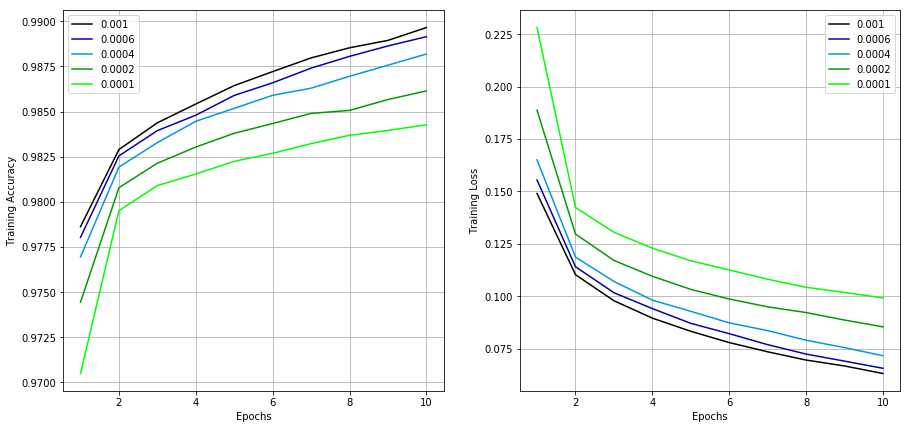

In [23]:
fg_train = plt.figure(figsize=(15, 7))

ax_acc_tr = get_axis(fg_train, 1)
for lr, h in zip(lr_list, history):
    ax_acc_tr.plot(
        range(1, len(h.history['acc'])+1), 
        h.history['acc'], 
        label=str(lr)
    )
pltSetUp('Training Accuracy')

ax_loss_tr = get_axis(fg_train, 2)
for lr, h in zip(lr_list, history):
    ax_loss_tr.plot(
        range(1, len(h.history['loss'])+1), 
        h.history['loss'], 
        label=str(lr)
    )
pltSetUp('Training Loss')

fg_train.show()

## 4.2 Validation Performane

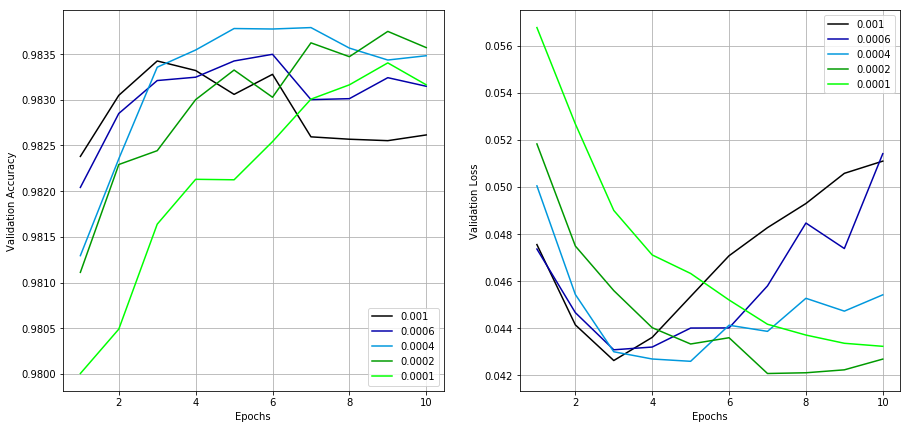

In [24]:
fg_valid = plt.figure(figsize=(15, 7))

ax_acc_va = get_axis(fg_valid, 1)
for lr, h in zip(lr_list, history):
    ax_acc_va.plot(
        range(1, len(h.history['val_acc'])+1), 
        h.history['val_acc'], 
        label=str(lr)
    )
pltSetUp('Validation Accuracy')

ax_loss_va = get_axis(fg_valid, 2)
for lr, h in zip(lr_list, history):
    ax_loss_va.plot(
        range(1, len(h.history['val_loss'])+1), 
        h.history['val_loss'], 
        label=str(lr)
    )
pltSetUp('Validation Loss')

plt.show()